In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from ipywidgets import Dropdown, IntSlider, interact #, Output, VBox
#from IPython.display import display

In [3]:
#load the dataset into a data frame
df = pd.read_csv("nigeria_houses_data.csv")

#convert the price in NGN to millions of NGN
df["price__millions"] = df["price"]/1e6

# Filter rows where the price is greater than or equal to 200 OR less than 1000 million NGN
p = range(10, 300)
mask_price = df["price__millions"].isin(p)

# Filter rows where the bedrooms are greater than or equal to 5 OR less than 9 million NGN
b = range(3, 9)
mask_bed = df["bedrooms"].isin(b)

# Filter rows with certain apartment type
mask_aptType = df["title"].isin(["Detached Duplex", "Terraced Duplexes", "Semi Detached Duplex", "Detached Bungalow"])

#Drop all rows with Anambra State
maskState = df["state"] != "Anambara"

# Filter rows with certain values
#mask_para =  (df["toilets"] >= 4) & (df["parking_space"] >= 2) & (df["bathrooms"] >= 3)

# Apply filters: price, apartment type, and states  
df = df[mask_bed & mask_price & mask_aptType & maskState]# & mask_para]

#drop unnecessary columns
df.drop(columns = ["price"], inplace = True)

In [5]:
df.tail(5)

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price__millions
24317,4.0,4.0,5.0,3.0,Terraced Duplexes,Lekki,Lagos,75.0
24318,4.0,5.0,5.0,4.0,Semi Detached Duplex,Lekki,Lagos,110.0
24320,3.0,4.0,4.0,5.0,Detached Duplex,Lekki,Lagos,80.0
24323,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,68.0
24325,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17913 entries, 2 to 24325
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         17913 non-null  float64
 1   bathrooms        17913 non-null  float64
 2   toilets          17913 non-null  float64
 3   parking_space    17913 non-null  float64
 4   title            17913 non-null  object 
 5   town             17913 non-null  object 
 6   state            17913 non-null  object 
 7   price__millions  17913 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.2+ MB


In [7]:
ghs = df.select_dtypes(include= ["float64", "int64"])
ghs = ghs.corr()
ghs

,bedrooms,bathrooms,toilets,parking_space,price__millions
bedrooms,1.000000,0.725835,0.720778,0.186576,0.444367
bathrooms,0.725835,1.000000,0.770666,0.193999,0.353299
toilets,0.720778,0.770666,1.000000,0.178378,0.392535
parking_space,0.186576,0.193999,0.178378,1.000000,0.123164
price__millions,0.444367,0.353299,0.392535,0.123164,1.000000


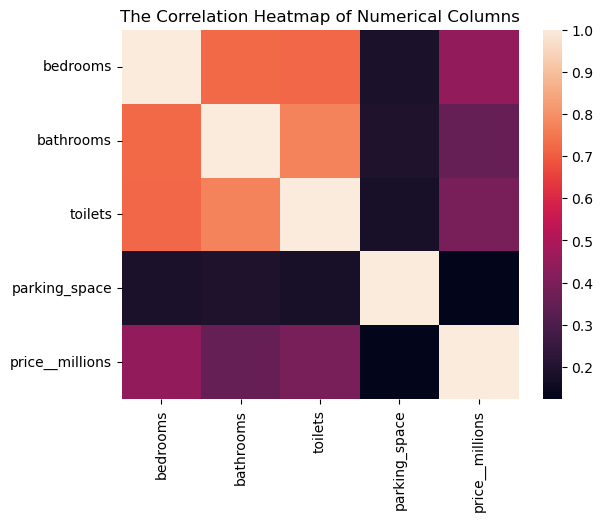

In [8]:
sns.heatmap(ghs)
plt.title("The Correlation Heatmap of Numerical Columns");

In [9]:
# Features
X = df[["title", "state", "bedrooms", "bathrooms", "toilets", "parking_space"]]
y = df["price__millions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Training and evaluating a Baseline Model to know if a random forest model performs well.
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
mae_baseline = round(mae_baseline, 2)
print("The Benchmark of the model is", mae_baseline)

The Benchmark of the model is 50.23


In [11]:
# Categorical columns to encode
catColumns = ["title", "state"]

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output = False, drop = "first", handle_unknown="ignore"), catColumns)
    ],
    remainder = "passthrough"
)

# Fit the transformer on training data and transform both X_train and X_test
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

C:\Users\abdul\miniconda3\envs\olatronics\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
Randmodel = RandomForestRegressor(n_estimators = 25, max_depth = 10, random_state = 42, verbose = 1)
Randmodel.fit(X_train_encoded, y_train)

RandomForestRegressor(max_depth=10, n_estimators=25, random_state=42, verbose=1)

In [13]:
        # Make predictions with the model
y_pred = Randmodel.predict(X_test_encoded)

    # Evaluate the performance of the model
mae_random = mean_absolute_error(y_test, y_pred)

if mae_random < mae_baseline:
    print("The Random Forest Regressor Model has a Good Mean Absolute Error of", round(mae_random, 2), "Million Naira")
else:
    print("The Random Forest Regressor Model has a Poor Mean Absolute Error of", round(mae_random, 2), "Million Naira")
print("The difference between the benchmark error and the Random Forest Regressor model error is:", round((mae_baseline - mae_random), 2))

The Random Forest Regressor Model has a Good Mean Absolute Error of 38.1 Million Naira
The difference between the benchmark error and the Random Forest Regressor model error is: 12.13


We are to choose the model with the lowest MAE


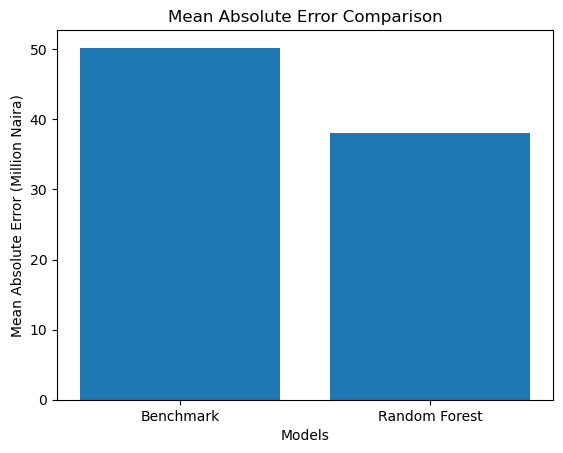

In [14]:
mae_values = [mae_baseline, mae_random]
labels = ["Benchmark", "Random Forest"]
plt.bar(labels, mae_values)
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (Million Naira)")
plt.title("Mean Absolute Error Comparison")
print("We are to choose the model with the lowest MAE");

In [16]:
# Categorical feature names
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(catColumns)

# Remaining (non-categorical) feature names
passthrough_features = X_train.columns.difference(catColumns)

# Combine all feature names
feature_names = list(onehot_feature_names) + list(passthrough_features)

#Get features' importance value
importances = Randmodel.feature_importances_

In [17]:
# Combine feature names and importances into a DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    #'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df.set_index("Feature", inplace=True)

# Display the feature importances
importances_df.head(5)

,Importance
Feature,
bathrooms,0.672329
toilets,0.060930
title_Detached Duplex,0.051345
bedrooms,0.032849
parking_space,0.031633


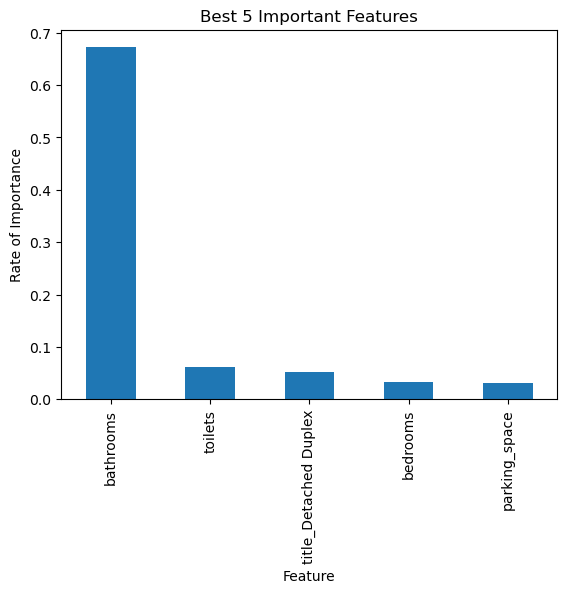

In [18]:
importances_df.head(5).plot(kind = "bar",
                           ylabel = "Rate of Importance",
                           title = "Best 5 Important Features",
                           legend = False);

In [21]:
# Prediction function
def predict_price(title, state, bedrooms, bathrooms, toilets, parking_space):# parking_space): 
    # Create a DataFrame with the user's input
    input_data = {
        "title": title,
        "state": state,
        "bedrooms": bedrooms,
        "toilets": toilets,
        "bathrooms": bathrooms,
        "parking_space": parking_space
    }
    df = pd.DataFrame(input_data, index = [0])

    # Transform the user input to the same preprocessing steps used in training
    df = preprocessor.transform(df)

    # Predict price using the trained model
    price_prediction = Randmodel.predict(df).round(2)[0]

    #return f"Predicted Price: {price_prediction[0]:.2f} Million NGN"
    return f"Predicted Price: {price_prediction} Million NGN"
    

In [22]:
# Create widgets
interact(
    predict_price,
    title = Dropdown(
        options=sorted(X_train["title"].unique()),
        description="Apartment Type"
    ),
    state = Dropdown(
         options=sorted(X_train["state"].unique()),
         description="State"
    ),
    bedrooms = IntSlider(
        min=int(X_train["bedrooms"].min()),
        max=int(X_train["bedrooms"].max()),
        value=int(X_train["bedrooms"].mean()),
        description="Bedrooms"
    ),
    toilets = IntSlider(
        min=int(X_train["toilets"].min()),
        max=int(X_train["toilets"].max()),
        value=int(X_train["toilets"].mean()),
        description="Toilets"
    ),
    bathrooms = IntSlider(
        min=int(X_train["bathrooms"].min()),
        max=int(X_train["bathrooms"].max()),
        value=int(X_train["bathrooms"].mean()),
        description="Bathrooms"
    ),
    
    parking_space = IntSlider(
        min=int(X_train["parking_space"].min()),
        max=int(X_train["parking_space"].max()),
        value=int(X_train["parking_space"].mean()),
        description="Parking Space"
    ),
    );

interactive(children=(Dropdown(description='Apartment Type', options=('Detached Bungalow', 'Detached Duplex', …